=== Random energy levels (eV) ===
    Species        E1        E2        E3        E4        E5
0        1  0.850489  0.115917  0.705469  0.687395  0.497573
1        2  0.532601  0.422196  0.308874  0.578203  0.468218
2        3  0.368837  0.660955  0.958071  0.481476  0.010586
3        4  0.089613  0.231260  0.109829  0.073347  0.163423
4        5  0.561693  0.801982  0.013758  0.306808  0.365735
5        6  0.347731  0.512252  0.808731  0.339793  0.290793
6        7  0.337620  0.002784  0.005413  0.073191  0.389486
7        8  0.651502  0.058782  0.837317  0.502970  0.234790
8        9  0.867796  0.827651  0.574465  0.415181  0.044841
9       10  0.236110  0.704672  0.699738  0.474606  0.924392

=== Derived thermodynamic features ===
    Species      AvgE       Entropy         Z         F  PctInaccess  \
0        1  0.115917  5.270409e-10  0.011288  0.115917         80.0   
1        2  0.310644  7.166031e-06  0.000007  0.308494          0.0   
2        3  0.010586  1.247044e-09  0.66

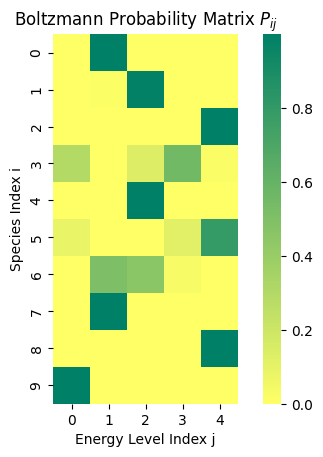

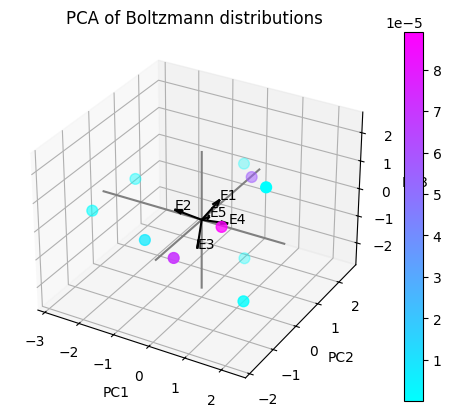

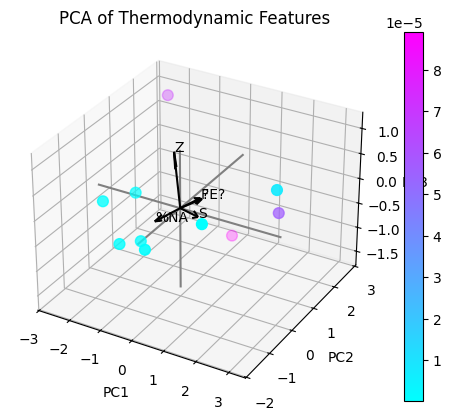

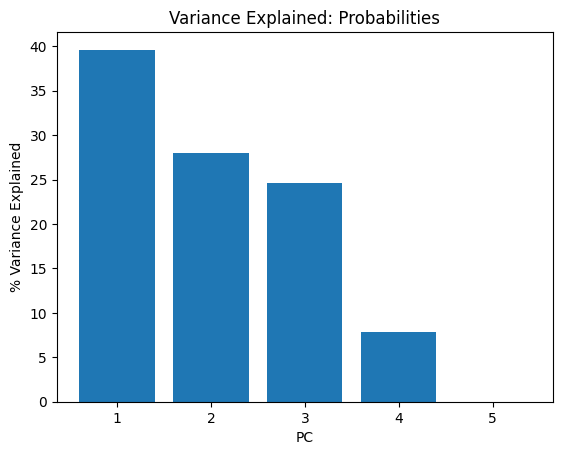

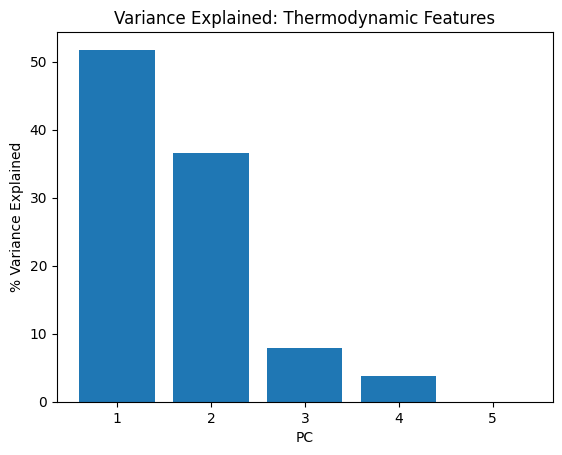

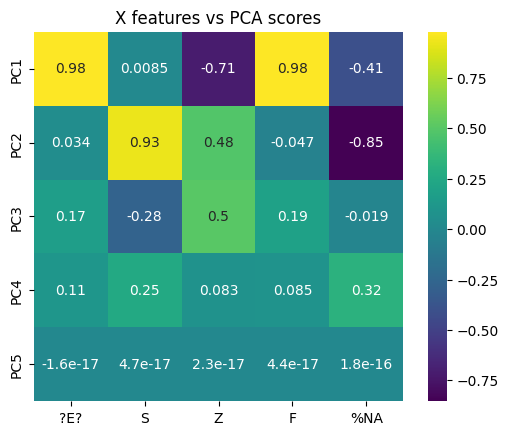

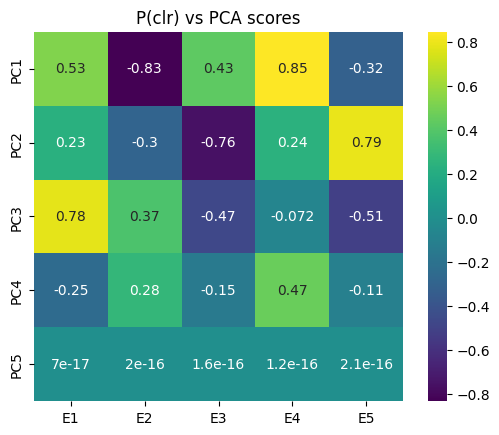

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import gmean

# --- User Inputs ---
n_species = 10
n_levels = 5
temp_options = [100, 200, 300, 400, 500]
temp_k = 300  # Default selection, can be replaced with dropdown
temp_idx = temp_options.index(temp_k)

color_options = ['AvgE', 'Entropy', 'Z', 'F', 'PctInaccess']
color_choice = 'Entropy'  # Default selection, can be replaced with dropdown

THRESH_P = 1e-6
PC_TO_PLOT = [0, 1, 2]  # zero-based in Python
N_LABEL = 5

# --- Constants ---
kB_eVK = 8.617e-5
beta = 1 / (kB_eVK * temp_k)

# --- 1. Generate random energy levels ---
E = np.random.rand(n_species, n_levels)
level_names = [f"E{j+1}" for j in range(n_levels)]
T_E = pd.DataFrame(E, columns=level_names)
T_E.insert(0, 'Species', np.arange(1, n_species+1))
print("=== Random energy levels (eV) ===\n", T_E)

# --- 2. Boltzmann statistics ---
Z = np.sum(np.exp(-beta * E), axis=1)
P = np.exp(-beta * E) / Z[:, None]
meanE = np.sum(P * E, axis=1)
S = -kB_eVK * np.sum(P * np.log(np.maximum(P, np.finfo(float).eps)), axis=1)
F = -kB_eVK * temp_k * np.log(Z)
pctNA = 100 * np.sum(P < THRESH_P, axis=1) / n_levels

T_thermo = pd.DataFrame({
    'Species': np.arange(1, n_species+1),
    'AvgE': meanE,
    'Entropy': S,
    'Z': Z,
    'F': F,
    'PctInaccess': pctNA,
    'PixelDarkness': pixel_darkness,
    'PixelNoise': pixel_noise
})
print("\n=== Derived thermodynamic features ===\n", T_thermo)

# --- 3. Visualize Boltzmann matrix ---
plt.figure()
sns.heatmap(P, cmap='summer_r', square=True, cbar=True)
plt.xlabel("Energy Level Index j")
plt.ylabel("Species Index i")
plt.title("Boltzmann Probability Matrix $P_{ij}$")
plt.show()

# --- 4. PCA on probability matrix ---
def clr(X):
    X_safe = X + np.finfo(float).eps
    gm = gmean(X_safe, axis=1)
    return np.log(X_safe / gm[:, None])

P_clr = clr(P)
P_scaled = StandardScaler().fit_transform(P_clr)
pca_P = PCA()
score_P = pca_P.fit_transform(P_scaled)
expl_P = pca_P.explained_variance_ratio_ * 100
coeff_P = pca_P.components_.T

# --- 5. PCA on thermo feature matrix ---
X = StandardScaler().fit_transform(T_thermo[['AvgE', 'Entropy', 'Z', 'F', 'PctInaccess']])
feat_names = ['?E?','S','Z','F','%NA']
pca_X = PCA()
score_X = pca_X.fit_transform(X)
expl_X = pca_X.explained_variance_ratio_ * 100
coeff_X = pca_X.components_.T

# --- 6. Plot PCA results ---
def draw_3d_axes(ax, color='gray'):
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    zlim = ax.get_zlim()
    ax.plot([xlim[0], xlim[1]], [0, 0], [0, 0], color=color)
    ax.plot([0, 0], [ylim[0], ylim[1]], [0, 0], color=color)
    ax.plot([0, 0], [0, 0], [zlim[0], zlim[1]], color=color)

def plot_pca_3d(scores, coeff, labels, color_values, title):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    p = ax.scatter(scores[:,0], scores[:,1], scores[:,2],
                   c=color_values, cmap='cool', s=60)
    scale = 0.4 * np.max(np.abs(scores))
    for i, label in enumerate(labels):
        ax.quiver(0, 0, 0,
                  coeff[i, 0]*scale,
                  coeff[i, 1]*scale,
                  coeff[i, 2]*scale,
                  color='black', linewidth=1.5)
        ax.text(coeff[i, 0]*scale,
                coeff[i, 1]*scale,
                coeff[i, 2]*scale,
                label, fontsize=10, color='black')
    draw_3d_axes(ax)
    fig.colorbar(p)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.set_title(title)
    plt.show()

plot_pca_3d(score_P, coeff_P, level_names, T_thermo[color_choice], "PCA of Boltzmann distributions")
plot_pca_3d(score_X, coeff_X, feat_names, T_thermo[color_choice], "PCA of Thermodynamic Features")

# --- 7. Variance Bar Plots ---
plt.figure()
plt.bar(range(1,6), expl_P[:5])
plt.xlabel('PC')
plt.ylabel('% Variance Explained')
plt.title('Variance Explained: Probabilities')
plt.show()

plt.figure()
plt.bar(range(1,6), expl_X[:5])
plt.xlabel('PC')
plt.ylabel('% Variance Explained')
plt.title('Variance Explained: Thermodynamic Features')
plt.show()

# --- 8. Correlation Heatmaps ---
def plot_corr_heatmap(scores, original_data, var_names, title):
    corr = np.corrcoef(scores.T, original_data.T)[:scores.shape[1], scores.shape[1]:]
    plt.figure()
    sns.heatmap(corr, xticklabels=var_names, yticklabels=[f"PC{i+1}" for i in range(scores.shape[1])],
                cmap='viridis', annot=True, square=True)
    plt.title(title)
    plt.show()

plot_corr_heatmap(score_X, X, feat_names, "X features vs PCA scores")
plot_corr_heatmap(score_P, P_clr, level_names, "P(clr) vs PCA scores")